# Imports and Functions

In [1]:
from datacube import Datacube
cdc = Datacube(config='/g/data/u46/users/ext547/ewater/cambodia_cube/cambodia.conf', app = "Polygon drill")
from datacube.storage.storage import write_dataset_to_netcdf

import fiona
import rasterio.features
import geopandas as gpd

import numpy as np
import xarray as xr
import pickle

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import matplotlib.animation as animation
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

from skimage import exposure

import calendar

#Import external dea-notebooks functions using relative link to Scripts directory
import sys
import os.path
sys.path.append('/g/data/u46/users/sc0554/dea-notebooks/10_Scripts/')
import DEAPlotting
import BandIndices
import seaborn as sns; sns.set()
import numpy as np; np.random.seed(0)

In [2]:
#Define function to create subplots of all scenes within an array as subplots
def one_band_image_subplots(ds, num_cols, figsize = [10,40], left  = 0.125, 
                              right = 0.9, bottom = 0.1, top = 0.9, 
                              wspace = 0.2, hspace = 0.4):
    '''
    one_band_image_subplots takes a dataset with one band and multiple time steps, 
    and plots them in image. 
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    num_cols - number of columns for the subplot
    
    Optional:
    figsize - dimensions for the output figure
    left  - the space on the left side of the subplots of the figure
    right - the space on the right side of the subplots of the figure
    bottom - the space on the bottom of the subplots of the figure
    top - the space on the top of the subplots of the figure
    wspace - the amount of width reserved for blank space between subplots
    hspace - the amount of height reserved for white space between subplots
    '''
    # Find the number of rows/columns we need, based on the number of time steps in ds
    fig = plt.figure(figsize = figsize)
    timesteps = ds.time.size
    num_rows = int(np.ceil(timesteps/num_cols))
    fig, axes = plt.subplots(num_rows, num_cols, figsize = figsize)
    fig.subplots_adjust(left  = left, right = right, bottom = bottom, top = top, 
                        wspace = wspace, hspace = hspace)
    try: #loop through all scenes, prepare imagery and create subplots
        for i, ax in enumerate(fig.axes):
            image_ds = ds.rainfall.isel(time =i)
            ax.set_title(str(image_ds.time.values)[0:10])
            ax.imshow(image_ds, interpolation = 'nearest') #plot image as subplot
    except IndexError: #if there are an odd number of plots, this code will allow plotting of images
        fig.delaxes(ax)
        plt.draw() 

In [3]:
#Define function to create a RGB composite images of all scenes within an array as subplots
def three_band_image(ds, bands,title,figsize = [10,10]):
    '''
    threeBandImage takes three spectral bands and plots them on the RGB bands of an 
    image. 
    
    Last modified: March 2018
    Author: Mike Barnes
    Modified by: Claire Krause and Erin Telfer
    Inputs: 
    ds -   Dataset containing the bands to be plotted
    bands - list of three bands to be plotted
    
    Optional:
    time - Index value of the time dimension of ds to be plotted
    figsize - dimensions for the output figure
    '''
    rgb = ds.to_array(dim='color').sel(color=bands).transpose('y', 'x', 'color')
    fake_saturation = 6000.0
    rgb = rgb.astype('double')
    clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
    print(type(clipped_visible))
    max_val = clipped_visible.max(['y', 'x'])
    scaled = (clipped_visible / max_val)

    fig = plt.figure(figsize = figsize)
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize=16)
    plt.imshow(scaled)

In [4]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [9]:
def calculate_indices(ds, index):
    '''
    Available indices are all calculated within the same function. If an
    index is requested that is not coded in the function, an error is
    raised.
    Try/except statements are used to account for the different band
    names for Landsat and Sentinel2 data.
    Available indices:
    - NDVI: Normalised Difference Vegetation Index
    - GNDVI: Green Normalised Difference Vegetation Index
    - NDWI: Normalised Difference Water Index
    - NDMI: Normalised Difference Moisture Index
    inputs:
    ds - dataset containing the bands needed for index calculation
    index - str of the index to be calculated
    outputs:
    indexout - result of the index calculation
    
    '''

    if index == 'NDWI':
        print('The formula we are using is (green - nir)/(green + nir)')
        try:
            indexout = ((ds.Band2 - ds.Band4)/(ds.Band2 + ds.Band4))
        except AttributeError:
            try:
                indexout = ((ds.green - ds.nir1)/(ds.green + ds.nir1))
            except:
                print('Error! NDWI requires green and nir bands')
    elif index == 'NDVI':
        print('The formula we are using is (nir - red)/(nir + red)')
        try:
            indexout = ((ds.Band4 - ds.Band3)/(ds.Band4 + ds.Band3))
        except AttributeError:
            try:
                indexout = ((ds.nir1 - ds.red)/(ds.nir1 + ds.red))
            except:
                print('Error! NDVI requires red and nir bands')
        print('Hmmmmm. I don\'t recognise that index. '
              'Options I currently have are NDVI, GNDVI, NDMI and NDWI.')

In [10]:
def write_your_netcdf(data, dataset_name, filename, crs):

    """
    This function turns an xarray dataarray into a dataset so we can write it to netcdf. 
    It adds on a crs definition from the original array. data = your xarray dataset, dataset_name 
    is a string describing your variable
    
    Last modified: May 2018
    Author: Bex Dunn    
    """ 
   
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs

    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))    

# Read in data

In [6]:
cambodia_spei = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/climate_indices_output/cambodia_spei.nc')
cambodia_masked_spei = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/climate_indices_output/cambodia_masked_spei.nc')
#cambodia_spei_gamma = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/climate_indices_output/cambodia_spei_gamma.nc')

In [ ]:
pet = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/climate_indices_input/pet_cambodia_1998_2016_monthly.nc')
pet = pet.isel(time=slice(2,len(pet.time)))
pet_masked = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/climate_indices_input/pet_cambodia_masked_1998_2016_monthly.nc')
pet_masked = pet_masked.isel(time=slice(2,len(pet_masked.time)))

rainfall = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/climate_indices_input/rainfall_cambodia_1998_2016_monthly.nc')
rainfall = rainfall.isel(time=slice(2,len(rainfall.time)))
rainfall_masked = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/climate_indices_input/rainfall_cambodia_masked_1998_2016_monthly.nc')
rainfall_masked = rainfall_masked.isel(time=slice(2,len(rainfall_masked.time)))


In [ ]:
kampongcchhnang_q1 = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/spei_geomedians_local/kampongcchhnang/spei_nbar_q1_geomedian.nc')
kampongcchhnang_q4 = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/spei_geomedians_local/kampongcchhnang/spei_nbar_q4_geomedian.nc')

In [ ]:
cambodia_spei_nbar_geomedian_q1 = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/spei_geomedians_national_quartile/q1_geomedian/q1_geomedian_masked.nc')

In [ ]:
cambodia_spei_nbar_geomedian_q4 =  xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/spei_geomedians_national_quartile/q4_geomedian/q4_geomedian_masked.nc')

# Plot and animate results

### Geomedians

In [ ]:
three_band_image(cambodia_spei_nbar_geomedian_q1,['swir1','nir', 'green'], title = 'SPEI Q1 - Landsat Geomedian')
plt.savefig('SPEI_q1_geomed.png')

In [ ]:
three_band_image(test,['swir1','nir', 'green'], title = 'SPEI Q2 - Landsat Geomedian')

In [ ]:
three_band_image(cambodia_spei_nbar_geomedian_q4,['band5','band4', 'band2'], title = 'SPEI Q4 - Landsat Geomedian')


In [ ]:
cambodia_spatial_mean_1 = BandIndices.calculate_indices(kampongcchhnang_q1, 'NDWI')
cambodia_spatial_mean_2 = BandIndices.calculate_indices(kampongcchhnang_q4, 'NDWI')
mean_spei_spatial_comparison = [cambodia_spatial_mean_1, cambodia_spatial_mean_2]

#input_shapefiles = ['/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/cambodia_boundary/KHM_adm0.shp', '/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/provinces/provinces.shp']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(10,10))
for dat, ax in zip(mean_spei_spatial_comparison, axes.flat):
    extents = [float(dat.x.min()), 
           float(dat.x.max()), 
           float(dat.y.min()), 
           float(dat.y.max())]
    im = ax.imshow(dat, vmin=-1, vmax=1, cmap = 'bwr_r', extent = extents, origin = 'lower')
#     for shapefile in input_shapefiles:
#             shapefile_overlay = gpd.read_file(shapefile)
#             shapefile_overlay.plot(ax = ax, linewidth=1, edgecolor='black', facecolor="#00000000")


axes[0].set_title("NDWI for Cambodia in SPEI Q1")
axes[1].set_title("NDWI for Cambodia in SPEI Q4")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal', pad = 0.002)#, shrink = 0.9)

plt.show()



In [ ]:
cambodia_spatial_mean_1 = calculate_indices(cambodia_spei_nbar_geomedian_q1, 'NDWI')
cambodia_spatial_mean_2 = calculate_indices(cambodia_spei_nbar_geomedian_q4, 'NDWI')
mean_spei_spatial_comparison = [cambodia_spatial_mean_1, cambodia_spatial_mean_2]

#input_shapefiles = ['/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/cambodia_boundary/KHM_adm0.shp', '/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/provinces/provinces.shp']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(10,10))
for dat, ax in zip(mean_spei_spatial_comparison, axes.flat):
    extents = [float(dat.x.min()), 
           float(dat.x.max()), 
           float(dat.y.min()), 
           float(dat.y.max())]
    im = ax.imshow(dat, vmin=-1, vmax=1, cmap = 'bwr_r', extent = extents, origin = 'lower')
#     for shapefile in input_shapefiles:
#             shapefile_overlay = gpd.read_file(shapefile)
#             shapefile_overlay.plot(ax = ax, linewidth=1, edgecolor='black', facecolor="#00000000")


axes[0].set_title("NDWI for Cambodia in SPEI Q1")
axes[1].set_title("NDWI for Cambodia in SPEI Q4")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal', pad = 0.002)#, shrink = 0.9)

plt.show()

**Plot each image at each time step**

In [ ]:
fig, axes = plt.subplots(100, 3, sharex='col', sharey='row', figsize = (12, 500))
for i in range(100):
    spei_plot = axes[i][0].imshow(cambodia_spei.spei_gamma_03.isel(time=i).values)
    plt.colorbar(spei_plot)
#     axes[i][1].imshow(monthly_environmental_data['rainfall'].rainfall.isel(time=i).values)
#     axes[i][2].imshow(monthly_environmental_data['pet'].pet.isel(time=i).values)
plt.tight_layout()
plt.show()

In [ ]:
# spei_03_seasonal_plot = cambodia_spei_03_seasonal.spei_gamma_03.plot(x='longitude', y = 'latitude', col='time', col_wrap=3)
# spei_06_seasonal_plot = cambodia_spei_06_seasonal.spei_gamma_06.plot(x='longitude', y = 'latitude', col='time', col_wrap=3)
# spei_12_seasonal_plot = cambodia_spei_12_seasonal.spei_gamma_12.plot(x='longitude', y = 'latitude', col='time', col_wrap=3)

### SPEI Timeseries


In [ ]:
#Comparison plot of mean SPEI for Cambodia over time at monthly interval for 3 different SPEI time scales
fig, ax1 = plt.subplots(figsize=(13,5))
cambodia_masked_spei.spei_gamma_03.mean(dim = ['latitude', 'longitude']).plot()
cambodia_masked_spei.spei_gamma_06.mean(dim = ['latitude', 'longitude']).plot()
cambodia_masked_spei.spei_gamma_12.mean(dim = ['latitude', 'longitude']).plot()
plt.xlabel('Years')
plt.ylabel('SPEI')
plt.legend(())
plt.title('Standardised Precipitation Evapotransipiration Index (SPEI) for Cambodia \n Decreasing SPEI values = increasing drought intensity')
plt.grid()
ax1.set_ylim(-3, 3)
ax1.axhline(y=0, color ='k', linestyle = 'dotted')
plt.tight_layout()
# fig.savefig('SPEI_12_masked.jpg')

In [ ]:
#Plot of mean SPEI for Cambodia at monthly interval for 3 month time scale comparing Gamma and Pearson distribution
fig, ax1 = plt.subplots(figsize=(13,5))
cambodia_spei.spei_gamma_03.mean(dim = ['latitude', 'longitude']).plot()
cambodia_spei.spei_pearson_03.mean(dim = ['latitude', 'longitude']).plot()
plt.xlabel('Years')
plt.ylabel('SPEI - 3 month')
plt.legend((plot1, plot2), ('SPEI 03 - Gamma', 'SPEI 03 - Pearson'))
plt.title('Standardised Precipitation Evapotransipiration Index (SPEI) for Cambodia \n Decreasing SPEI values = increasing drought intensity')
plt.grid()
ax1.set_ylim(-3, 3)
ax1.axhline(y=0, color ='k', linestyle = 'dotted')
plt.tight_layout()
fig.savefig('SPEI_03_.jpg')

In [ ]:
### Plot SPEI and input variables on the same axis

fig, ax1 = plt.subplots(figsize=(13,5))
fig.subplots_adjust(right=0.75)

speiplot, = ax1.plot(cambodia_masked_spei.time, cambodia_masked_spei.spei_gamma_03.mean(dim = ['latitude', 'longitude']), 'r-')
ax1.set_xlabel('Year')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('SPEI - 03 month')

ax2 = ax1.twinx()
rainfallplot, = ax2.plot(cambodia_masked_spei.time, rainfall_masked.rainfall.mean(dim = ['latitude', 'longitude']), 'b-')
ax2.set_ylabel('precipitation (monthly total / mm)')

# ax3 = ax1.twinx()
# petplot, = ax3.plot(cambodia_masked_spei.time, pet_masked.pet.mean(dim = ['latitude', 'longitude']), 'g-')
# ax3.set_ylabel('PET')
# ax3.set_ylim(80,140)

# ax3.spines["right"].set_position(("axes", 1.2))
# make_patch_spines_invisible(ax3)
# ax3.spines["right"].set_visible(True)

ax1.yaxis.label.set_color(speiplot.get_color())
ax2.yaxis.label.set_color(rainfallplot.get_color())
# ax3.yaxis.label.set_color(petplot.get_color())

tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', colors=speiplot.get_color(), **tkw)
ax2.tick_params(axis='y', colors=rainfallplot.get_color(), **tkw)
# ax3.tick_params(axis='y', colors=petplot.get_color(), **tkw)
ax1.tick_params(axis='x', **tkw)

ax1.set_ylim(-2.5, 2.5)
plt.grid()
# ax1.axhline(y=0, color ='k', linestyle = 'dotted')
# ax2.axhline(y=0, color ='k', linestyle = 'dotted')
#ax1.axhline(y=0, color ='k', linestyle = 'dotted')
plt.title('Standardised Precipitation Evapotransipiration Index (SPEI) and precipitation for Cambodia \n Decreasing SPEI values = Increasing drought intensity')
fig.tight_layout()
plt.show()

fig.savefig('SPEI_03_rainfall_comparison_masked.jpg')

### SPEI Heatmap

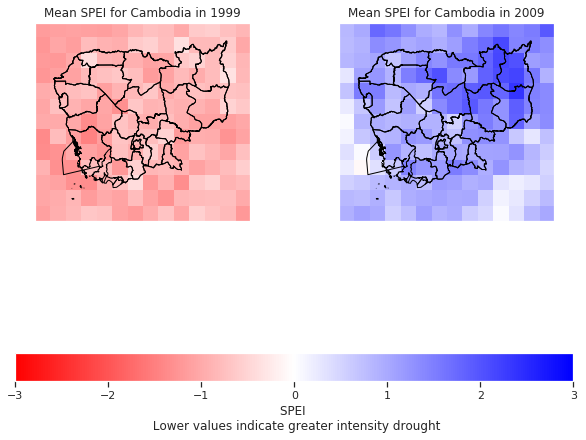

In [7]:
# from mpl_toolkits import axes_grid1

### Plot of the mean SPEI value for a time slice over the spatial area
#Shows the likelihood of particular areas to be drought effected
cambodia_spatial_mean_1 = cambodia_spei.spei_gamma_03.loc[dict(
    time=slice('1999-01-01', '1999-12-31'))].mean(dim = 'time')
cambodia_spatial_mean_2 = cambodia_spei.spei_gamma_03.loc[dict(
    time=slice('2009-01-01', '2009-12-01'))].mean(dim= 'time')

mean_spei_spatial_comparison = [cambodia_spatial_mean_1, cambodia_spatial_mean_2]

input_shapefiles = ['/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/cambodia_boundary/KHM_adm0.shp', '/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/provinces/provinces.shp']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(10,10))
for dat, ax in zip(mean_spei_spatial_comparison, axes.flat):
    extents = [float(dat.longitude.min()), 
           float(dat.longitude.max()), 
           float(dat.latitude.min()), 
           float(dat.latitude.max())]
    im = ax.imshow(dat, vmin=-3, vmax=3, cmap = 'bwr_r', extent = extents)
    for shapefile in input_shapefiles:
            shapefile_overlay = gpd.read_file(shapefile)
            shapefile_overlay.plot(ax = ax, linewidth=1, edgecolor='black', facecolor="#00000000")


axes[0].set_title("Mean SPEI for Cambodia in 1999")
axes[1].set_title("Mean SPEI for Cambodia in 2009")
axes[0].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_xticklabels([])
axes[1].set_yticklabels([])
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
fig.colorbar(im,  ax=axes.ravel().tolist(), orientation='horizontal', 
             label = 'SPEI \n Lower values indicate greater intensity drought', pad = 0.002)#, shrink = 0.9)
                  
# add shapefile overlay
        
# shapefile_overlay.plot('ax':ax1, 'linewidth':2, 'edgecolor':'black', 'facecolor':"#00000000"}, 
#                                     **shapefile_overlay_kwargs)

plt.show()

# fig, (a1, a2) = plt.subplots(1, 2, figsize = (10,10))
# spei_2005 = a1.imshow(cambodia_spei_2005, vmin = -3, vmax = 3, cmap = 'bwr_r')
# spei_2009 = a2.imshow(cambodia_spei_2009, vmin = -3, vmax =3, cmap = 'bwr_r')

# a1.set_title("Mean SPEI for Cambodia in 1998")
# a2.set_title("Mean SPEI for Cambodia in 2009")
fig.savefig('SPEI_spatialcomparison_1999_2009.png')


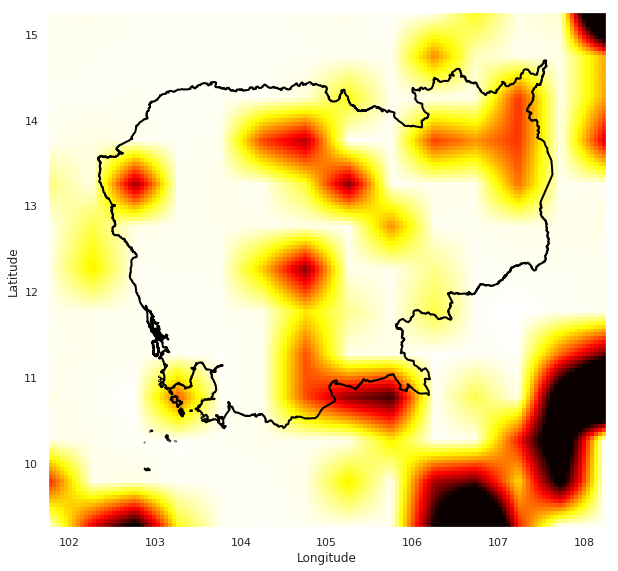

In [50]:
#Shows the likelihood of particular areas to be drought effected

cambodia_spei_spatial_mean = cambodia_spei.spei_gamma_03.mean(dim= 'time')

new_lon = np.linspace(cambodia_spei_spatial_mean.longitude[0], cambodia_spei_spatial_mean.longitude[-1], 
                      cambodia_spei_spatial_mean.longitude.size * 10)
new_lat = np.linspace(cambodia_spei_spatial_mean.latitude[0], cambodia_spei_spatial_mean.latitude[-1], 
                      cambodia_spei_spatial_mean.latitude.size * 10)

cambodia_spei_spatial_mean_interp = cambodia_spei_spatial_mean.interp(latitude=new_lat, longitude=new_lon)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize =(10,10))
extents = [float(cambodia_spei_spatial_mean.longitude.min()), 
           float(cambodia_spei_spatial_mean.longitude.max()), 
           float(cambodia_spei_spatial_mean.latitude.min()), 
           float(cambodia_spei_spatial_mean.latitude.max())]

im = axes.imshow(cambodia_spei_spatial_mean_interp, 
                 cmap = 'hot', extent = extents, vmin=-.003)

shapefile_overlay = gpd.read_file('/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/cambodia_boundary/KHM_adm0.shp')
shapefile_overlay.plot(ax = axes, linewidth=2, edgecolor='black', facecolor="#00000000")

# fig.colorbar(im)
# axes.set_title("Heatmap of Drought intensity")
axes.set_ylabel("Latitude")
axes.set_xlabel("Longitude")
axes.grid(False)
fig.savefig('SPEI.png')



In [36]:
pet = xr.open_dataset('/g/data/u46/users/sc0554/drought_indices_cambodia/climate_indices_input/pet_cambodia_1998_2016_monthly.nc')

In [38]:
cambodia_spei_spatial_mean_interp.to_netcdf('cambodia_spei_heatmap2.nc')

In [37]:
cambodia_spei_spatial_mean_interp.attrs['units'] = 'spei_03'
write_your_netcdf(cambodia_spei_spatial_mean_interp, 'spei_03_heatmap', 'cambodia_spei_heatmap.nc', pet.crs)

AttributeError: 'DataArray' object has no attribute 'units'

In [ ]:
cambodia_spei_spatial_mean = cambodia_spei.spei_gamma_03.mean(dim= 'time')

new_lon = np.linspace(cambodia_spei_spatial_mean.longitude[0], cambodia_spei_spatial_mean.longitude[-1], 
                      cambodia_spei_spatial_mean.longitude.size * 3)
new_lat = np.linspace(cambodia_spei_spatial_mean.latitude[0], cambodia_spei_spatial_mean.latitude[-1], 
                      cambodia_spei_spatial_mean.latitude.size * 3)

cambodia_spei_spatial_mean_interp = cambodia_spei_spatial_mean.interp(latitude=new_lat, longitude=new_lon)
shapefile_overlay = gpd.read_file('/g/data/u46/users/ext547/ewater/input_data/Cambodia_boundary/KHM_Basin_Simple_A.shp')
shapefile_overlay.to_crs({'init':'EPSG:4326'}, inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize =(7,7))

sns.heatmap(cambodia_spei_spatial_mean_interp.values, center = 0, 
                 cmap = 'bwr_r', xticklabels=True, yticklabels=True, cbar=False, ax=axes)

shapefile_overlay.plot(ax = axes, linewidth=2, edgecolor='black', facecolor="#00000000")

### Animation Creation Station

In [ ]:
input_shapefiles = ['/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/provinces/provinces.shp']
DEAPlotting.animated_timeseries(ds = cambodia_spei_03, output_path='/g/data/u46/users/sc0554/drought_indices_cambodia/plots_animations/spei_03_test.gif',
                    bands = ['spei_gamma_03'], show_date= False, onebandplot_cbar=True, x_dim = 'longitude', y_dim = 'latitude', title= "SPEI Cambodia" + cambodia_spei_03.time.dt.year.values.tolist(), shapefile_path = input_shapefiles,
                    onebandplot_kwargs={'cmap':'bwr_r', 'vmin':-3, 'vmax':3}, interval=200)


In [ ]:
input_shapefiles = ['/g/data/u46/users/sc0554/shapefiles/provinces/provinces.shp']
animated_timeseries(ds = nbar_clean.isel(time=[1, 2, 3, 4, 5, 6, 7 ,8 ,9]), output_path='/g/data/u46/users/sc0554/climate_indices_output/spei_03_test.gif',
                    bands = ['swir1', 'green', 'nir'], show_date= True, onebandplot_cbar=True, shapefile_path = input_shapefiles,
                    onebandplot_kwargs={'cmap':'bwr_r', 'vmin':0, 'vmax':4000})


In [ ]:
input_shapefiles = ['/g/data/u46/users/sc0554/drought_indices_cambodia/shapefiles/provinces/provinces.shp']
# cambodia_spei_03_xy = cambodia_spei_03.rename({'latitude':'y', 'longitude': 'x'})
# rainfall_xy = monthly_environmental_data['rainfall'].rename({'latitude':'y', 'longitude': 'x'})

DEAPlotting.animated_doubletimeseries(ds1 = cambodia_spei_03, ds2= monthly_environmental_data['rainfall'], output_path='/g/data/u46/users/sc0554/drought_indices_cambodia/plots_animations/SPEI_rainfall.gif', 
                                bands1 = ['spei_gamma_03'], bands2 = ['rainfall'], shapefile_path1 = input_shapefiles, shapefile_path2 = input_shapefiles,
                          title1="SPEI", title2='Rainfall',
                          onebandplot_kwargs1={'cmap':'bwr_r', 'vmin':-3, 'vmax':3}, onebandplot_kwargs2={'cmap':'Blues', 'vmin':0, 'vmax':400}, interval=350, x_dim1 = 'longitude', y_dim1 = 'latitude', x_dim2 = 'longitude', y_dim2 = 'latitude')

In [ ]:
monthly_environmental_data['rainfall']

In [ ]:
input_shapefiles = ['/g/data/u46/users/sc0554/shapefiles/provinces/provinces.shp']
#cambodia_spei_03_xy = cambodia_spei_03.rename({'latitude':'y', 'longitude': 'x'})
# rainfall_xy = monthly_environmental_data['rainfall'].rename({'latitude':'y', 'longitude': 'x'})


animated_doubletimeseries(ds1 = cambodia_spei_03, ds2= nbar_clean, output_path='/g/data/u46/users/sc0554/climate_indices_output/SPEI_rainfall.gif', 
                                bands1 = ['spei_gamma_03'], bands2 = ['swir1'], shapefile_path1 = input_shapefiles, shapefile_path2 = input_shapefiles,
                          title1="SPEI", title2='skrrt',
                          onebandplot_kwargs1={'cmap':'bwr_r', 'vmin':-3, 'vmax':3}, onebandplot_kwargs2={'cmap':'bwr_r', 'vmin':-3, 'vmax':3}, interval=200, x_dim1 = 'longitude', y_dim1 = 'latitude', x_dim2 = 'x', y_dim2 = 'y')

In [ ]:
nbar_clean

In [ ]:
monthly_environmental_data['rainfall']